In [8]:

# import the necessary packages
from tensorflow.keras.models import load_model
from imutils.contours import sort_contours
import numpy as np
import argparse
import imutils
import cv2
import matplotlib.pyplot as plt
import os

In [2]:
print("[INFO] loading handwriting OCR model...")
model = load_model('handwriting.model')

[INFO] loading handwriting OCR model...


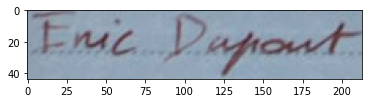

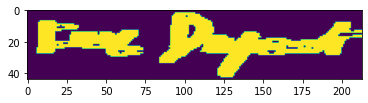

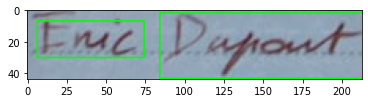

In [17]:
image = cv2.imread('C:/Users/Yasmine/Downloads/fraud-detection-main/segmented_img/image12.png')
plt.imshow(image)
im2=image.copy()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
# perform edge detection, find contours in the edge map, and sort the
# resulting contours from left-to-right
edged = cv2.Canny(blurred, 30, 150)
rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (8, 1))
dilation = cv2.dilate(edged, rect_kernel, iterations = 1)
plt.figure()
plt.imshow(dilation)
contours,contr_img = cv2.findContours(dilation,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
j=0
#os.chdir('./segmented_img/')
for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(im2, (x, y), (x + w, y + h), (0, 255, 0), 1)
        roi=image[y:y+h,x:x+w]
        dim=(40, 40)
        #roi=cv2.resize(roi, dim, interpolation = cv2.INTER_AREA)
        cv2.imwrite("segmented_word/word"+str(j)+".png",roi)
        j=j+1
plt.figure()
plt.imshow(im2)

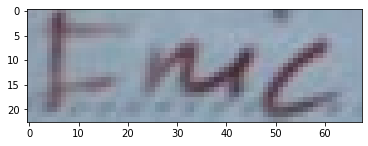

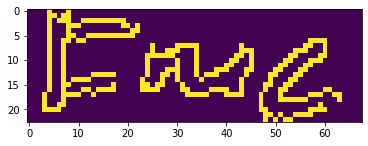

In [18]:
# load the input image from disk, convert it to grayscale, and blur
# it to reduce noise
image = cv2.imread('C:/Users/Yasmine/Downloads/fraud-detection-main/segmented_word/word0.png')
plt.imshow(image)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
# perform edge detection, find contours in the edge map, and sort the
# resulting contours from left-to-right
edged = cv2.Canny(blurred, 30, 150)
plt.figure()
plt.imshow(edged)
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sort_contours(cnts, method="left-to-right")[0]
# initialize the list of contour bounding boxes and associated
# characters that we'll be OCR'ing
chars = []

In [19]:
# loop over the contours
for c in cnts:
    # compute the bounding box of the contour
    (x, y, w, h) = cv2.boundingRect(c)
    # filter out bounding boxes, ensuring they are neither too small
    # nor too large
    if (w >= 5 and w <= 150) and (h >= 15 and h <= 120):
        # extract the character and threshold it to make the character
        # appear as *white* (foreground) on a *black* background, then
        # grab the width and height of the thresholded image
        roi = gray[y:y + h, x:x + w]
        thresh = cv2.threshold(roi, 0, 255,
            cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        (tH, tW) = thresh.shape
        # if the width is greater than the height, resize along the
        # width dimension
        if tW > tH:
            thresh = imutils.resize(thresh, width=32)
        # otherwise, resize along the height
        else:
            thresh = imutils.resize(thresh, height=32)
        # re-grab the image dimensions (now that its been resized)
        # and then determine how much we need to pad the width and
        # height such that our image will be 32x32
        (tH, tW) = thresh.shape
        dX = int(max(0, 32 - tW) / 2.0)
        dY = int(max(0, 32 - tH) / 2.0)
        # pad the image and force 32x32 dimensions
        padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY,
            left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,
            value=(0, 0, 0))
        padded = cv2.resize(padded, (32, 32))
        # prepare the padded image for classification via our
        # handwriting OCR model
        padded = padded.astype("float32") / 255.0
        padded = np.expand_dims(padded, axis=-1)
        # update our list of characters that will be OCR'd
        chars.append((padded, (x, y, w, h)))

In [20]:
# extract the bounding box locations and padded characters
boxes = [b[1] for b in chars]
chars = np.array([c[0] for c in chars], dtype="float32")
# OCR the characters using our handwriting recognition model
print(chars.shape)

(2, 32, 32, 1)


[INFO] F - 48.20%
[INFO] C - 79.54%


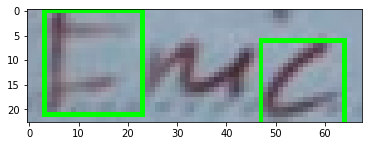

In [21]:
preds = model.predict(chars)
# define the list of label names
labelNames = "0123456789"
labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
labelNames = [l for l in labelNames]
img=image.copy()
# loop over the predictions and bounding box locations together
for (pred, (x, y, w, h)) in zip(preds, boxes):
    # find the index of the label with the largest corresponding
    # probability, then extract the probability and label
    i = np.argmax(pred)
    prob = pred[i]
    label = labelNames[i]
    # draw the prediction on the image
    print("[INFO] {} - {:.2f}%".format(label, prob * 100))
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 1)
    cv2.putText(img, label, (x - 10, y - 10),
        cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2)
    # show the image
    #cv2.namedWindow('Image')
    #cv2.imshow("Image", image)
    #cv2.waitKey(0)
    plt.imshow(img)